# Анализ данных Certificate Transparency для домена wb.ru

## Практическое задание №1: Пассивная разведка поддоменов

Данный ноутбук содержит анализ данных из открытых источников (Certificate Transparency logs) для сбора информации о поддоменах домена wb.ru.


In [6]:
import json
import pandas as pd
from collections import Counter
import re
from datetime import datetime
import matplotlib.pyplot as plt
import seaborn as sns
from urllib.parse import urlparse

# Настройка отображения
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
pd.set_option('display.width', None)
pd.set_option('display.max_colwidth', 100)

print("Библиотеки загружены успешно")


Библиотеки загружены успешно


## 0. Проверка файла перед загрузкой


In [7]:
# Быстрая проверка структуры файла
import os

file_path = 'crt.json'
file_size = os.path.getsize(file_path)
print(f"Размер файла: {file_size / (1024*1024):.2f} MB ({file_size:,} байт)")

# Проверяем первые символы файла
with open(file_path, 'r', encoding='utf-8') as f:
    first_chars = f.read(100)
    print(f"\nПервые 100 символов файла:")
    print(first_chars)
    
# Подсчитываем примерное количество записей (если это массив)
if first_chars.strip().startswith('['):
    print("\n✓ Файл начинается с '[', это JSON массив")
    # Быстрый подсчет записей по открывающим скобкам объектов
    with open(file_path, 'r', encoding='utf-8') as f:
        content_sample = f.read(min(100000, file_size))  # Читаем первые 100KB
        estimated_records = content_sample.count('"id":')
        print(f"Примерное количество записей (по первым 100KB): ~{estimated_records}")
        if file_size > 100000:
            full_estimate = int(estimated_records * (file_size / 100000))
            print(f"Оценочное общее количество записей: ~{full_estimate:,}")
else:
    print("\n⚠ Файл не начинается с '[', проверьте формат")


Размер файла: 0.37 MB (390,197 байт)

Первые 100 символов файла:
[{"issuer_ca_id":295816,"issuer_name":"C=US, O=Let's Encrypt, CN=R12","common_name":"xs.wb.ru","name

✓ Файл начинается с '[', это JSON массив
Примерное количество записей (по первым 100KB): ~296
Оценочное общее количество записей: ~1,154


## 1. Загрузка данных из crt.json

**Внимание:** Если загрузка занимает слишком много времени, попробуйте использовать ячейку ниже с оптимизированной загрузкой.


In [20]:
# Загрузка данных из файла crt.json
# Используем ujson если доступен (быстрее стандартного json)
print("Начинаю загрузку данных из crt.json...")

try:
    import ujson
    json_loader = ujson
    print("Используется ujson (быстрая загрузка)")
except ImportError:
    json_loader = json
    print("Используется стандартный json")
    print("(Для ускорения установите: pip install ujson)")

try:
    with open('crt.json', 'r', encoding='utf-8') as f:
        print("Читаю JSON файл (это может занять некоторое время для больших файлов)...")
        import time
        start_time = time.time()
        crt_data = json_loader.load(f)
        elapsed = time.time() - start_time
        print(f"✓ Загружено записей о сертификатах: {len(crt_data):,}")
        print(f"Время загрузки: {elapsed:.2f} секунд")
        
    if len(crt_data) > 0:
        print(f"\nПример первой записи:")
        # Показываем только ключи для экономии места
        first_keys = list(crt_data[0].keys())
        print(f"Ключи в записи: {first_keys}")
        print(f"\nПолная первая запись:")
        print(json.dumps(crt_data[0], indent=2, ensure_ascii=False))
        
except MemoryError as e:
    print(f"❌ Ошибка памяти: {e}")
    print("\nПопробуйте использовать альтернативный метод загрузки в следующей ячейке")
    crt_data = None
except json.JSONDecodeError as e:
    print(f"❌ Ошибка парсинга JSON: {e}")
    print("Возможно, файл поврежден или имеет неверный формат")
    crt_data = None
except Exception as e:
    print(f"❌ Ошибка: {type(e).__name__}: {e}")
    crt_data = None


Начинаю загрузку данных из crt.json...
Используется стандартный json
(Для ускорения установите: pip install ujson)
Читаю JSON файл (это может занять некоторое время для больших файлов)...
✓ Загружено записей о сертификатах: 1,165
Время загрузки: 0.00 секунд

Пример первой записи:
Ключи в записи: ['issuer_ca_id', 'issuer_name', 'common_name', 'name_value', 'id', 'entry_timestamp', 'not_before', 'not_after', 'serial_number', 'result_count']

Полная первая запись:
{
  "issuer_ca_id": 295816,
  "issuer_name": "C=US, O=Let's Encrypt, CN=R12",
  "common_name": "xs.wb.ru",
  "name_value": "*.xs.wb.ru\nxs.wb.ru",
  "id": 23355092314,
  "entry_timestamp": "2025-12-25T06:45:57.091",
  "not_before": "2025-12-25T05:47:25",
  "not_after": "2026-03-25T05:47:24",
  "serial_number": "0631061b6681fab5e6dad7d9728e17895dbb",
  "result_count": 3
}


### Альтернативный метод загрузки (если стандартный не работает)

Используйте эту ячейку, если предыдущая загрузка не работает или занимает слишком много времени.


In [21]:
# Альтернативный метод: потоковая загрузка через ijson
# Раскомментируйте и используйте, если стандартная загрузка не работает

# try:
#     import ijson
#     print("Используем потоковую обработку через ijson...")
#     crt_data = []
#     with open('crt.json', 'rb') as f:
#         parser = ijson.items(f, 'item')
#         count = 0
#         for item in parser:
#             crt_data.append(item)
#             count += 1
#             if count % 1000 == 0:
#                 print(f"Загружено записей: {count:,}", end='\r')
#     print(f"\n✓ Загружено записей о сертификатах: {len(crt_data):,}")
# except ImportError:
#     print("ijson не установлен. Установите: pip install ijson")
#     crt_data = None

print("Эта ячейка закомментирована. Раскомментируйте код выше, если нужна потоковая загрузка.")


Эта ячейка закомментирована. Раскомментируйте код выше, если нужна потоковая загрузка.


## 2. Извлечение поддоменов из данных Certificate Transparency


In [22]:
def extract_subdomains(crt_data):
    """
    Извлекает все поддомены из данных Certificate Transparency
    """
    if crt_data is None:
        print("❌ Данные не загружены. Сначала загрузите данные из crt.json")
        return [], []
    
    subdomains = set()
    certificates_info = []
    
    total = len(crt_data)
    print(f"Обрабатываю {total:,} записей...")
    
    for i, cert in enumerate(crt_data):
        # Показываем прогресс каждые 1000 записей
        if (i + 1) % 1000 == 0 or (i + 1) == total:
            progress = ((i + 1) / total) * 100
            print(f"Прогресс: {i + 1}/{total} ({progress:.1f}%)", end='\r')
        
        # Извлекаем домены из поля name_value
        name_value = cert.get('name_value', '')
        if name_value:
            # Разделяем по переносу строки и очищаем
            domains = [d.strip() for d in name_value.split('\n') if d.strip()]
            for domain in domains:
                # Убираем wildcard префикс
                domain = domain.replace('*.', '')
                # Проверяем, что это поддомен wb.ru
                if domain.endswith('.wb.ru') or domain == 'wb.ru':
                    subdomains.add(domain)
        
        # Также добавляем common_name если он есть
        common_name = cert.get('common_name', '')
        if common_name:
            common_name = common_name.replace('*.', '')
            if common_name.endswith('.wb.ru') or common_name == 'wb.ru':
                subdomains.add(common_name)
        
        # Сохраняем информацию о сертификате
        cert_info = {
            'id': cert.get('id'),
            'common_name': cert.get('common_name', ''),
            'name_value': cert.get('name_value', ''),
            'issuer_name': cert.get('issuer_name', ''),
            'entry_timestamp': cert.get('entry_timestamp', ''),
            'not_before': cert.get('not_before', ''),
            'not_after': cert.get('not_after', ''),
        }
        certificates_info.append(cert_info)
    
    print()  # Новая строка после прогресса
    return sorted(list(subdomains)), certificates_info

if crt_data is not None:
    subdomains, certs_info = extract_subdomains(crt_data)
    print(f"\n✓ Найдено уникальных поддоменов: {len(subdomains)}")
    print(f"\nПервые 20 поддоменов:")
    for i, subdomain in enumerate(subdomains[:20], 1):
        print(f"{i}. {subdomain}")
else:
    print("Данные не загружены. Используйте альтернативный метод загрузки.")


Обрабатываю 1,165 записей...
Прогресс: 1165/1165 (100.0%)

✓ Найдено уникальных поддоменов: 62

Первые 20 поддоменов:
1. 3d.wb.ru
2. ad.wb.ru
3. adp.wb.ru
4. alias.wb.ru
5. antifraud.wb.ru
6. autodiscover.wb.ru
7. bank.wb.ru
8. bitrix24.wb.ru
9. bnpl.wb.ru
10. ccvpn.wb.ru
11. cisco.dl.wb.ru
12. cisco.dp.wb.ru
13. core-dwh.wb.ru
14. da.wb.ru
15. dev.wb.ru
16. dl.wb.ru
17. dll.wb.ru
18. dm.wb.ru
19. dnd.wb.ru
20. dp.wb.ru


## 3. Анализ данных по источникам (Certificate Transparency)


In [23]:
# Создаем DataFrame для анализа
df_certs = pd.DataFrame(certs_info)

# Преобразуем даты
df_certs['entry_timestamp'] = pd.to_datetime(df_certs['entry_timestamp'], errors='coerce')
df_certs['not_before'] = pd.to_datetime(df_certs['not_before'], errors='coerce')
df_certs['not_after'] = pd.to_datetime(df_certs['not_after'], errors='coerce')

# Анализ издателей сертификатов
print("=== Анализ издателей сертификатов ===")
issuer_counts = df_certs['issuer_name'].value_counts()
print(issuer_counts)
print(f"\nВсего уникальных издателей: {df_certs['issuer_name'].nunique()}")


=== Анализ издателей сертификатов ===
issuer_name
C=US, O=Let's Encrypt, CN=R3                                                                                     596
C=US, O=Let's Encrypt, CN=R11                                                                                    168
C=US, O=Let's Encrypt, CN=R10                                                                                    148
C=US, O=Let's Encrypt, CN=Let's Encrypt Authority X3                                                              90
C=US, O=Let's Encrypt, CN=R12                                                                                     66
C=US, O=Let's Encrypt, CN=R13                                                                                     48
C=BE, O=GlobalSign nv-sa, CN=GlobalSign GCC R6 AlphaSSL CA 2023                                                   24
C=BE, O=GlobalSign nv-sa, CN=GlobalSign GCC R6 AlphaSSL CA 2025                                                   10
C=BE, O=Global

In [24]:
# Анализ временных меток
print("=== Временной анализ ===")
print(f"Самый ранний сертификат: {df_certs['entry_timestamp'].min()}")
print(f"Самый поздний сертификат: {df_certs['entry_timestamp'].max()}")
print(f"Период данных: {(df_certs['entry_timestamp'].max() - df_certs['entry_timestamp'].min()).days} дней")

# Группировка по месяцам
df_certs['entry_month'] = df_certs['entry_timestamp'].dt.to_period('M')
monthly_counts = df_certs['entry_month'].value_counts().sort_index()
print("\nКоличество сертификатов по месяцам:")
print(monthly_counts)


=== Временной анализ ===
Самый ранний сертификат: 2018-01-26 20:23:33.357000
Самый поздний сертификат: 2025-12-25 06:45:57.091000
Период данных: 2889 дней

Количество сертификатов по месяцам:
entry_month
2018-01     1
2018-10     2
2018-11     2
2018-12     2
2019-02     4
2019-03     6
2019-04     4
2019-05     2
2019-06     2
2019-07     2
2019-08     4
2019-10     7
2019-12     4
2020-01     4
2020-02     6
2020-03     6
2020-05     8
2020-06     6
2020-07     4
2020-08     6
2020-09     4
2020-10     6
2020-11     2
2020-12    10
2021-01    14
2021-02     4
2021-03    18
2021-04     8
2021-05    16
2021-06     2
2021-07    20
2021-08     2
2021-09    20
2021-10     2
2021-11    16
2021-12     2
2022-01    30
2022-02     2
2022-03    32
2022-04     2
2022-05    18
2022-06     9
2022-07    20
2022-08     6
2022-09    20
2022-10     6
2022-11    20
2022-12     8
2023-01    20
2023-02     6
2023-03    22
2023-04    10
2023-05    22
2023-06     9
2023-07    22
2023-08     8
2023-09    2

## 4. Группировка и сортировка поддоменов


In [25]:
def categorize_subdomain(subdomain):
    """
    Категоризирует поддомены по их структуре
    """
    if subdomain == 'wb.ru':
        return 'Основной домен'
    
    # Убираем .wb.ru для анализа
    prefix = subdomain.replace('.wb.ru', '')
    
    # Анализ структуры
    parts = prefix.split('.')
    
    if len(parts) == 1:
        return 'Первый уровень'
    elif len(parts) == 2:
        return 'Второй уровень'
    else:
        return 'Третий уровень и выше'

# Категоризация поддоменов
subdomain_categories = {}
for subdomain in subdomains:
    category = categorize_subdomain(subdomain)
    if category not in subdomain_categories:
        subdomain_categories[category] = []
    subdomain_categories[category].append(subdomain)

# Вывод результатов по категориям
print("=== Группировка поддоменов по уровням ===")
for category, subdomains_list in sorted(subdomain_categories.items()):
    print(f"\n{category}: {len(subdomains_list)} поддоменов")
    for subdomain in sorted(subdomains_list)[:10]:  # Показываем первые 10
        print(f"  - {subdomain}")
    if len(subdomains_list) > 10:
        print(f"  ... и еще {len(subdomains_list) - 10} поддоменов")


=== Группировка поддоменов по уровням ===

Второй уровень: 6 поддоменов
  - cisco.dl.wb.ru
  - cisco.dp.wb.ru
  - ikev2-stgswan.dl.wb.ru
  - mail.corp.wb.ru
  - mta-sts.dnd.wb.ru
  - www.dnd.wb.ru

Основной домен: 1 поддоменов
  - wb.ru

Первый уровень: 55 поддоменов
  - 3d.wb.ru
  - ad.wb.ru
  - adp.wb.ru
  - alias.wb.ru
  - antifraud.wb.ru
  - autodiscover.wb.ru
  - bank.wb.ru
  - bitrix24.wb.ru
  - bnpl.wb.ru
  - ccvpn.wb.ru
  ... и еще 45 поддоменов


In [26]:
# Анализ префиксов поддоменов (первые части перед точками)
def get_first_level_prefix(subdomain):
    """Извлекает первый уровень поддомена"""
    if subdomain == 'wb.ru':
        return 'wb.ru'
    parts = subdomain.replace('.wb.ru', '').split('.')
    return parts[-1] if parts else subdomain

prefix_counter = Counter([get_first_level_prefix(sd) for sd in subdomains])

print("=== Топ-20 наиболее часто встречающихся префиксов первого уровня ===")
for prefix, count in prefix_counter.most_common(20):
    print(f"{prefix}: {count} поддомен(ов)")


=== Топ-20 наиболее часто встречающихся префиксов первого уровня ===
dl: 3 поддомен(ов)
dnd: 3 поддомен(ов)
dp: 2 поддомен(ов)
3d: 1 поддомен(ов)
ad: 1 поддомен(ов)
adp: 1 поддомен(ов)
alias: 1 поддомен(ов)
antifraud: 1 поддомен(ов)
autodiscover: 1 поддомен(ов)
bank: 1 поддомен(ов)
bitrix24: 1 поддомен(ов)
bnpl: 1 поддомен(ов)
ccvpn: 1 поддомен(ов)
core-dwh: 1 поддомен(ов)
da: 1 поддомен(ов)
dev: 1 поддомен(ов)
dll: 1 поддомен(ов)
dm: 1 поддомен(ов)
dpl: 1 поддомен(ов)
el: 1 поддомен(ов)


## 5. Детальный анализ поддоменов


In [15]:
# Создаем DataFrame с поддоменами
df_subdomains = pd.DataFrame({
    'subdomain': subdomains,
    'level': [categorize_subdomain(sd) for sd in subdomains],
    'prefix': [get_first_level_prefix(sd) for sd in subdomains]
})

# Статистика
print("=== Статистика по поддоменам ===")
print(f"Всего уникальных поддоменов: {len(df_subdomains)}")
print(f"\nРаспределение по уровням:")
print(df_subdomains['level'].value_counts())

print(f"\nУникальных префиксов первого уровня: {df_subdomains['prefix'].nunique()}")


=== Статистика по поддоменам ===
Всего уникальных поддоменов: 62

Распределение по уровням:
level
Первый уровень    55
Второй уровень     6
Основной домен     1
Name: count, dtype: int64

Уникальных префиксов первого уровня: 57


## 6. Визуализация данных


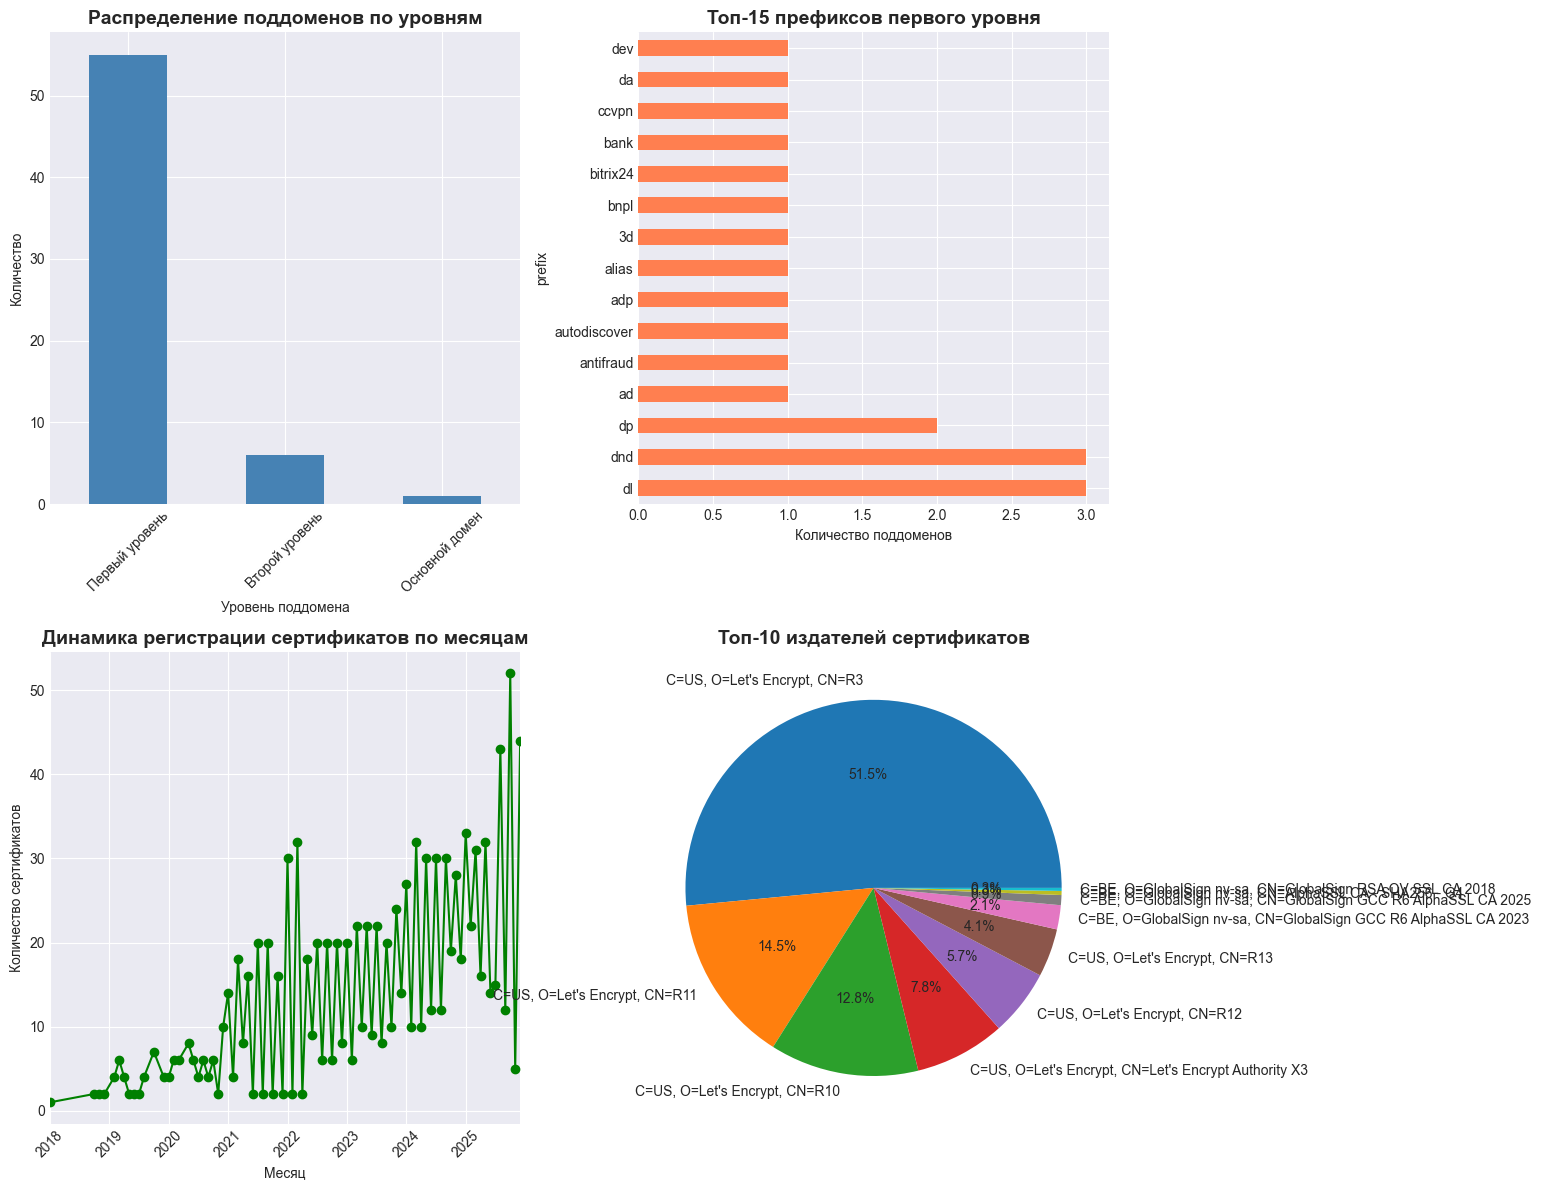

In [ ]:
# Настройка стиля графиков
try:
    plt.style.use('seaborn-v0_8-darkgrid')
except:
    try:
        plt.style.use('seaborn-darkgrid')
    except:
        plt.style.use('default')
        
fig, axes = plt.subplots(2, 2, figsize=(15, 12))

# График 1: Распределение по уровням
df_subdomains['level'].value_counts().plot(kind='bar', ax=axes[0, 0], color='steelblue')
axes[0, 0].set_title('Распределение поддоменов по уровням', fontsize=14, fontweight='bold')
axes[0, 0].set_xlabel('Уровень поддомена')
axes[0, 0].set_ylabel('Количество')
axes[0, 0].tick_params(axis='x', rotation=45)

# График 2: Топ-15 префиксов
top_prefixes = df_subdomains['prefix'].value_counts().head(15)
top_prefixes.plot(kind='barh', ax=axes[0, 1], color='coral')
axes[0, 1].set_title('Топ-15 префиксов первого уровня', fontsize=14, fontweight='bold')
axes[0, 1].set_xlabel('Количество поддоменов')

# График 3: Временная динамика (если есть данные)
if not df_certs['entry_month'].isna().all():
    monthly_counts.plot(kind='line', ax=axes[1, 0], marker='o', color='green')
    axes[1, 0].set_title('Динамика регистрации сертификатов по месяцам', fontsize=14, fontweight='bold')
    axes[1, 0].set_xlabel('Месяц')
    axes[1, 0].set_ylabel('Количество сертификатов')
    axes[1, 0].tick_params(axis='x', rotation=45)

# График 4: Распределение издателей
top_issuers = df_certs['issuer_name'].value_counts().head(10)
top_issuers.plot(kind='pie', ax=axes[1, 1], autopct='%1.1f%%')
axes[1, 1].set_title('Топ-10 издателей сертификатов', fontsize=14, fontweight='bold')
axes[1, 1].set_ylabel('')

plt.tight_layout()
plt.show()


## 7. Экспорт результатов


In [17]:
# Сохранение списка поддоменов в текстовый файл
with open('subdomains_crt.txt', 'w', encoding='utf-8') as f:
    for subdomain in sorted(subdomains):
        f.write(f"{subdomain}\n")

print(f"Список поддоменов сохранен в файл 'subdomains_crt.txt'")
print(f"Всего поддоменов: {len(subdomains)}")

# Сохранение детального отчета в CSV
df_subdomains.to_csv('subdomains_analysis.csv', index=False, encoding='utf-8-sig')
print(f"Детальный анализ сохранен в файл 'subdomains_analysis.csv'")


Список поддоменов сохранен в файл 'subdomains_crt.txt'
Всего поддоменов: 62
Детальный анализ сохранен в файл 'subdomains_analysis.csv'


## 8. Выводы и анализ возможностей источника Certificate Transparency

### Преимущества использования Certificate Transparency logs:
1. **Полнота данных**: CT logs содержат информацию обо всех выпущенных SSL/TLS сертификатах
2. **Исторические данные**: Можно отслеживать изменения во времени
3. **Пассивный метод**: Не требует прямого взаимодействия с целевой инфраструктурой
4. **Автоматизация**: Данные доступны через API и могут быть автоматизированы

### Ограничения:
1. **Только SSL/TLS поддомены**: Находятся только те поддомены, для которых выпущены сертификаты
2. **Отсутствие внутренних поддоменов**: Не показывает поддомены без публичных сертификатов
3. **Задержка данных**: Может быть небольшая задержка между выпуском сертификата и его появлением в логах
4. **Wildcard сертификаты**: Могут скрывать конкретные поддомены под общим wildcard сертификатом

### Сравнение с другими источниками:
Для полноты картины рекомендуется использовать дополнительные источники:
- DNS enumeration (DNSrecon, dnsrecon)
- Search engines (Google dorking)
- Shodan, Censys
- VirusTotal
- PassiveTotal
- SecurityTrails


In [28]:
# Итоговая статистика
print("=" * 60)
print("ИТОГОВАЯ СТАТИСТИКА АНАЛИЗА")
print("=" * 60)
print(f"Источник данных: Certificate Transparency logs")
print(f"Целевой домен: wb.ru")
print(f"Всего записей о сертификатах: {len(crt_data)}")
print(f"Уникальных поддоменов найдено: {len(subdomains)}")
print(f"\nРаспределение по уровням:")
for level, count in df_subdomains['level'].value_counts().items():
    print(f"  {level}: {count}")
print(f"\nУникальных префиксов первого уровня: {df_subdomains['prefix'].nunique()}")
print(f"Уникальных издателей сертификатов: {df_certs['issuer_name'].nunique()}")
if not df_certs['entry_timestamp'].isna().all():
    print(f"Период данных: {df_certs['entry_timestamp'].min().date()} - {df_certs['entry_timestamp'].max().date()}")
print("=" * 60)


ИТОГОВАЯ СТАТИСТИКА АНАЛИЗА
Источник данных: Certificate Transparency logs
Целевой домен: wb.ru
Всего записей о сертификатах: 1165
Уникальных поддоменов найдено: 62

Распределение по уровням:
  Первый уровень: 55
  Второй уровень: 6
  Основной домен: 1

Уникальных префиксов первого уровня: 57
Уникальных издателей сертификатов: 14
Период данных: 2018-01-26 - 2025-12-25
